## Objective:
In this notebook, we explore the presence of volatility clustering in stocks across various sectors by analyzing return series and computing clustering scores.

Volatility clustering is a phenomenon where high-volatility periods tend to follow high-volatility periods, and low follows low. Detecting clustering is important for selecting appropriate volatility models.

- We visualize the log returns and ACF of squared returns for several stocks to examine the persistence in volatility over time.
- We visualize the log returns and ACF of squared returns for several stocks to examine the persistence in volatility over time.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from data import stock_data
from wfwGARCH import clusteringTest, GARCHWalkForward
from hvPred import HVmodel

In [18]:
con = sqlite3.connect('stock_data.db', check_same_thread=False)

In [13]:
finance = [
    "JPM",  # JPMorgan Chase
    "BAC",  # Bank of America
    "C",    # Citigroup
    "GS",   # Goldman Sachs
    "MS",   # Morgan Stanley
    "AXP",  # American Express
    "WFC",  # Wells Fargo
    "USB",  # U.S. Bancorp
    "PNC",  # PNC Financial Services
    "SCHW"  # Charles Schwab
]

tech = [
    "AAPL",  # Apple
    "MSFT",  # Microsoft
    "NVDA",  # Nvidia
    "GOOGL", # Alphabet (Google)
    "AMD",   # Advanced Micro Devices
    "INTC",  # Intel
    "TSLA",  # Tesla (tech-adjacent)
    "CRM",   # Salesforce
    "ORCL",  # Oracle
    "AVGO"   # Broadcom
]

etf = [
    "SPY",   # S&P 500 ETF
    "QQQ",   # Nasdaq 100 ETF
    "IWM",   # Russell 2000 ETF
    "VXX",   # Volatility ETF
    "XLK",   # Technology Sector ETF
    "XLF",   # Financial Sector ETF
    "ARKK",  # ARK Innovation ETF
    "DIA",   # Dow Jones ETF
    "EEM",   # Emerging Markets ETF
    "TLT"    # 20+ Year Treasury Bond ETF
]

health_tech = [
    "MRNA",  # Moderna Inc.
    "BIIB",  # Biogen Inc.
    "VRTX",  # Vertex Pharmaceuticals
    "REGN",  # Regeneron Pharmaceuticals
    "ILMN",  # Illumina Inc.
    "DXCM",  # Dexcom Inc.
    "CRSP",  # CRISPR Therapeutics (mid-cap but very volatile)
    "NVCR"   # NovoCure Ltd. (mid-cap, high volatility)
]

commodity = [
    # Energy
    "XOM",  # Exxon Mobil
    "CVX",  # Chevron
    "SLB",  # Schlumberger

    # Metals & Mining
    "NEM",  # Newmont Corporation (Gold)
    "GOLD", # Barrick Gold
    "FCX",  # Freeport-McMoRan (Copper)

    # Agriculture
    "ADM",  # Archer Daniels Midland
    "MOS",  # Mosaic (Fertilizers)
    "BG"    # Bunge Ltd.
]


In [14]:
all_stocks = finance + tech + etf + health_tech +commodity
len(all_stocks)

47

In [20]:
stock_list=list(pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", con)['name'])

### Download and insert data into stock_data.db

In [23]:
for st in all_stocks:
    if st not in stock_list:
        dt = stock_data(st,ticker=st)
        dt.get_daily('full')
        dt.insert_table(con, if_exists='replace')


### Get data for different sectors

In [28]:
def get_stock_data(stock_list):
    df_dict = {}
    for st in stock_list:
        dt = stock_data(st,)
        df = dt.load_data(con)
        df_dict[st] = df
    return df_dict

In [32]:
df_finance = get_stock_data(finance)
df_tech = get_stock_data(tech)
df_etf = get_stock_data(etf)
df_health_tech = get_stock_data(health_tech)
df_commodity = get_stock_data(commodity)


## Calculate clustering score for different sectors

In [70]:
def clustering(df_dict, sector):
    res = {}
    for st in df_dict.keys():
        ct = clusteringTest(df_dict[st]['returns'],st)
        score = ct.clusteringScore()
        res[st]=[sector,len(df_dict[st]),score]
    return res


## Finance Sector

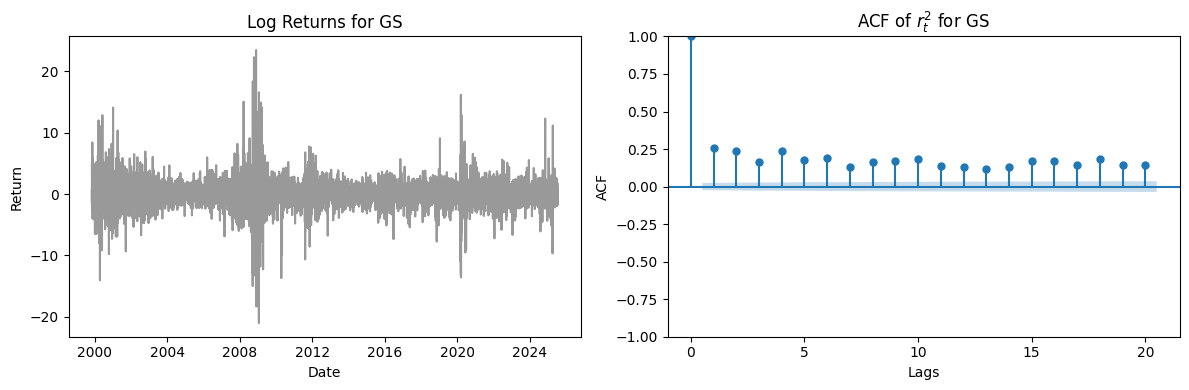

In [67]:
GS_ct = clusteringTest(df_finance['GS']['returns'],'GS')
GS_ct.plotACF()

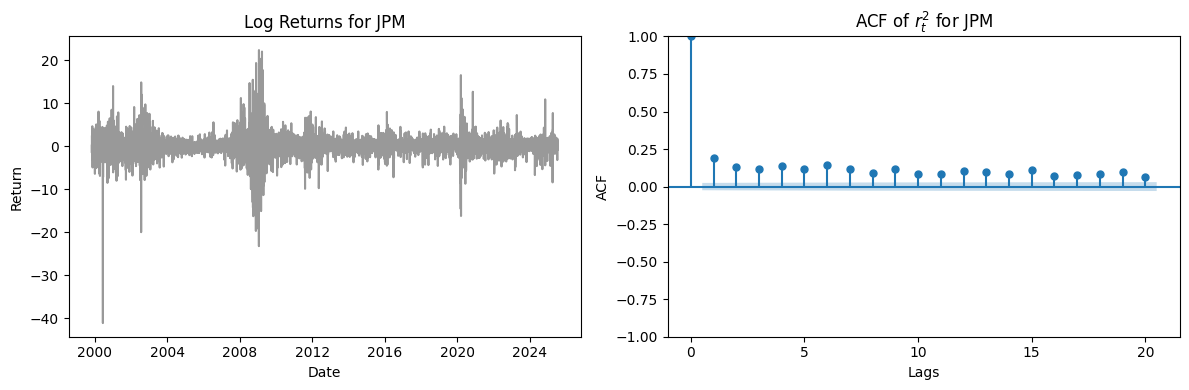

In [75]:
JPM_ct = clusteringTest(df_finance['JPM']['returns'],'JPM')
JPM_ct.plotACF()

In [71]:
finance_clustering_dict = clustering(df_finance,'Finance')

In [72]:
finance_clustering = pd.DataFrame.from_dict(finance_clustering_dict, orient='index', columns=['Sector', '#Observations','Clustering Score'])

In [73]:
finance_clustering.sort_values(by='Clustering Score', ascending=False)

,Sector,#Observations,Clustering Score
GS,Finance,6463,1.069
JPM,Finance,6463,0.697
SCHW,Finance,6463,0.611
USB,Finance,6463,0.609
PNC,Finance,6463,0.581
MS,Finance,6463,0.493
BAC,Finance,6463,0.391
WFC,Finance,6463,0.186
AXP,Finance,6463,0.020
C,Finance,6463,0.008


## Tech Sector

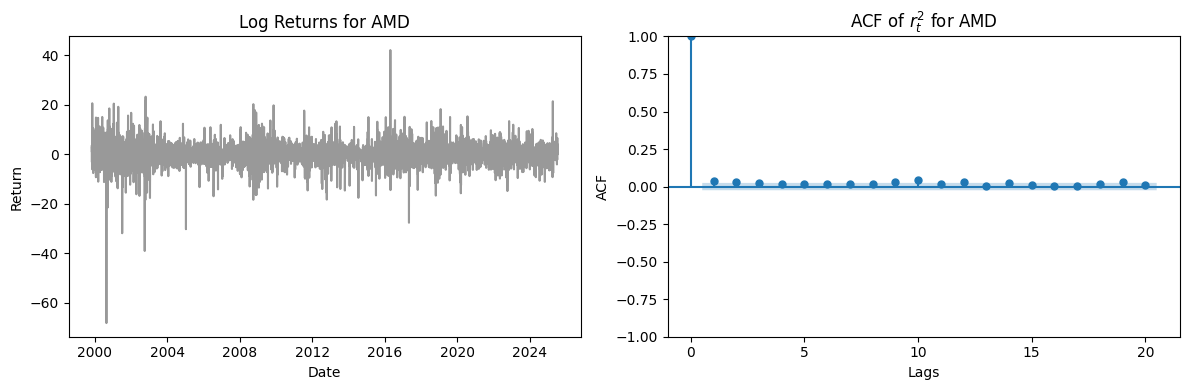

In [78]:
AMD_ct = clusteringTest(df_tech['AMD']['returns'],'AMD')
AMD_ct.plotACF()

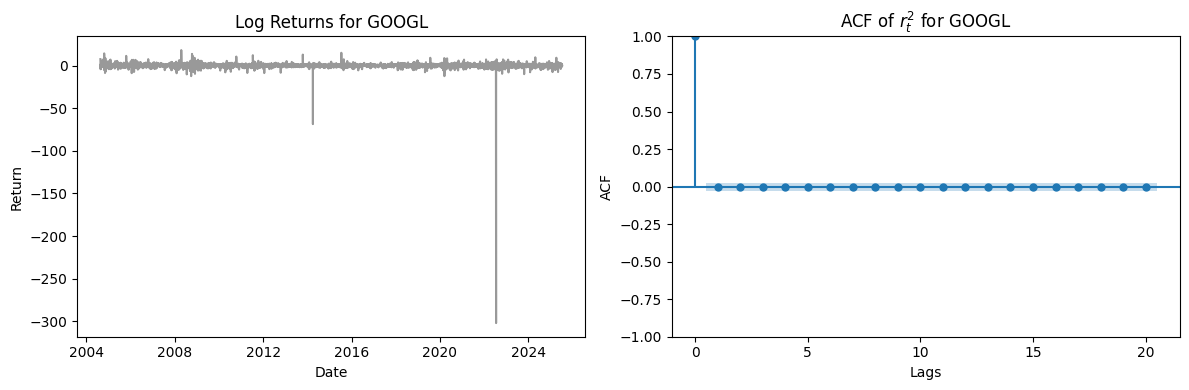

In [80]:
GOOGL_ct = clusteringTest(df_tech['GOOGL']['returns'],'GOOGL')
GOOGL_ct.plotACF()

In [20]:
tech_clustering_dict = clustering(df_tech, sector='Technology')

In [21]:
tech_clustering = pd.DataFrame.from_dict(tech_clustering_dict, orient='index', columns=['Sector', '#Observations','Clustering Score'])

In [22]:
tech_clustering.sort_values(by='Clustering Score', ascending=False)

,Sector,#Observations,Clustering Score
AMD,Technology,6463,0.115
INTC,Technology,6463,0.092
ORCL,Technology,6463,0.092
MSFT,Technology,6463,0.034
TSLA,Technology,3783,0.021
NVDA,Technology,6463,0.002
AAPL,Technology,6463,-0.000
CRM,Technology,5298,-0.000
AVGO,Technology,4008,-0.000
GOOGL,Technology,5258,-0.001


## ETF sector

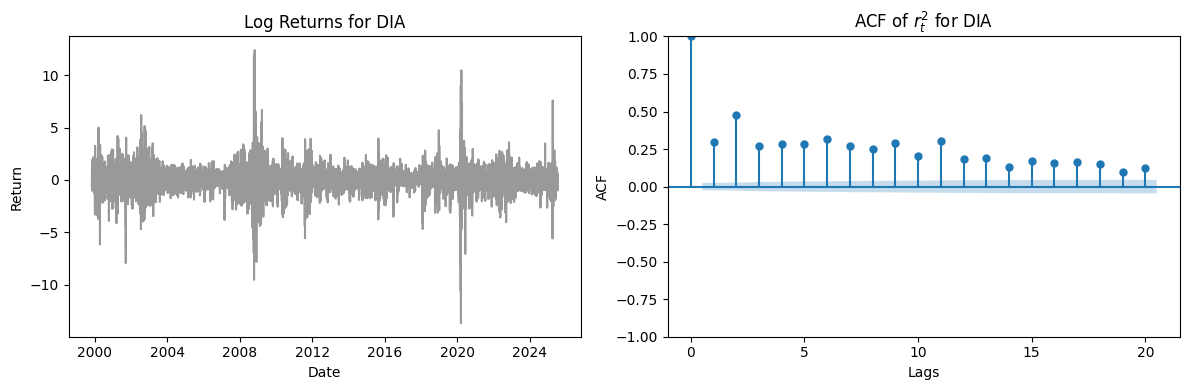

In [82]:
DIA_ct = clusteringTest(df_etf['DIA']['returns'],'DIA')
DIA_ct.plotACF()

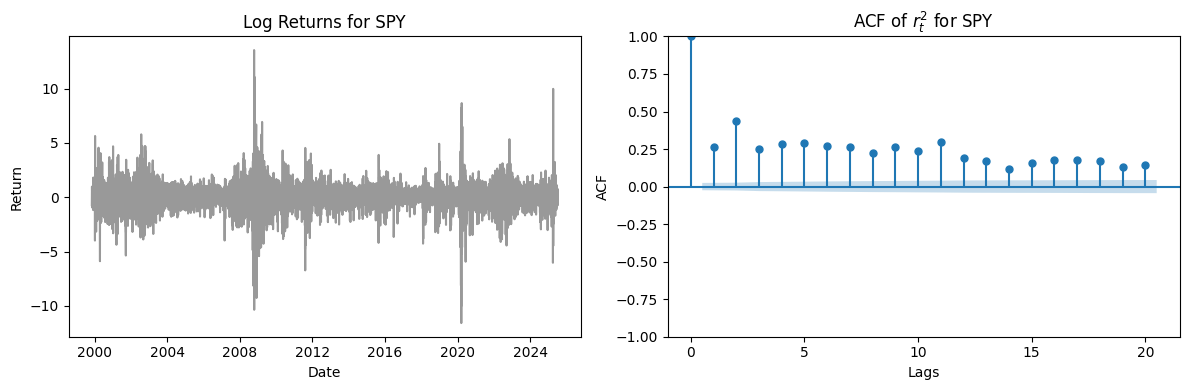

In [83]:
SPY_ct = clusteringTest(df_etf['SPY']['returns'],'SPY')
SPY_ct.plotACF()

In [23]:
etf_clustering_dict = clustering(df_etf, sector="ETF")

In [24]:
etf_clustering = pd.DataFrame.from_dict(etf_clustering_dict, orient='index', columns=['Sector', '#Observations','Clustering Score'])

In [25]:
etf_clustering.sort_values(by='Clustering Score', ascending=False)

,Sector,#Observations,Clustering Score
DIA,ETF,6465,1.615
SPY,ETF,6458,1.528
TLT,ETF,5780,1.507
XLF,ETF,6465,1.290
ARKK,ETF,2691,1.269
XLK,ETF,6465,1.219
QQQ,ETF,6457,0.034
IWM,ETF,6321,0.014
EEM,ETF,5600,0.002
VXX,ETF,4140,-0.008


## Health Tech Sector

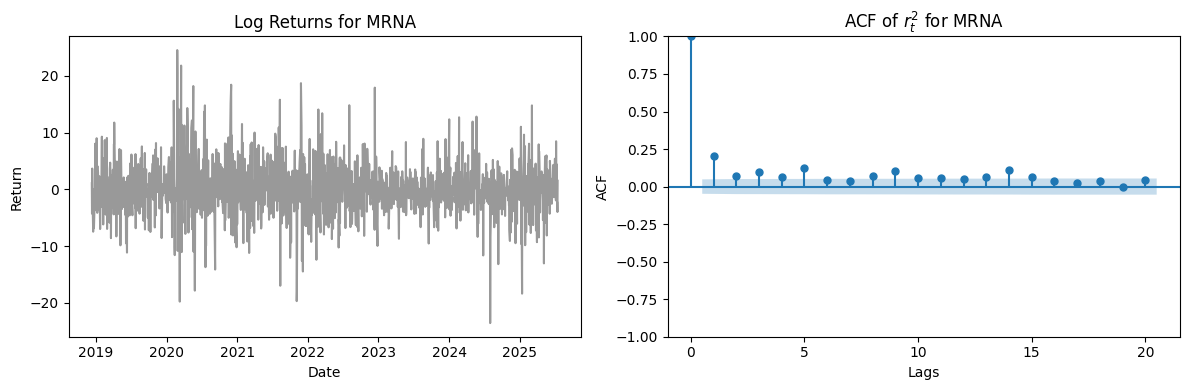

In [84]:
MRNA_ct = clusteringTest(df_health_tech['MRNA']['returns'],'MRNA')
MRNA_ct.plotACF()

In [26]:
health_tech_clustering_dict = clustering(df_health_tech, sector="Health Tech")

In [27]:
health_tech_clustering = pd.DataFrame.from_dict(health_tech_clustering_dict, orient='index', columns=['Sector', '#Observations','Clustering Score'])

In [28]:
health_tech_clustering.sort_values(by='Clustering Score', ascending=False)

,Sector,#Observations,Clustering Score
MRNA,Health Tech,1658,0.558
CRSP,Health Tech,2196,0.286
REGN,Health Tech,6464,0.183
ILMN,Health Tech,6277,0.166
VRTX,Health Tech,6464,0.119
NVCR,Health Tech,2460,0.065
BIIB,Health Tech,6464,0.043
DXCM,Health Tech,5095,0.004


## Commodities Sector

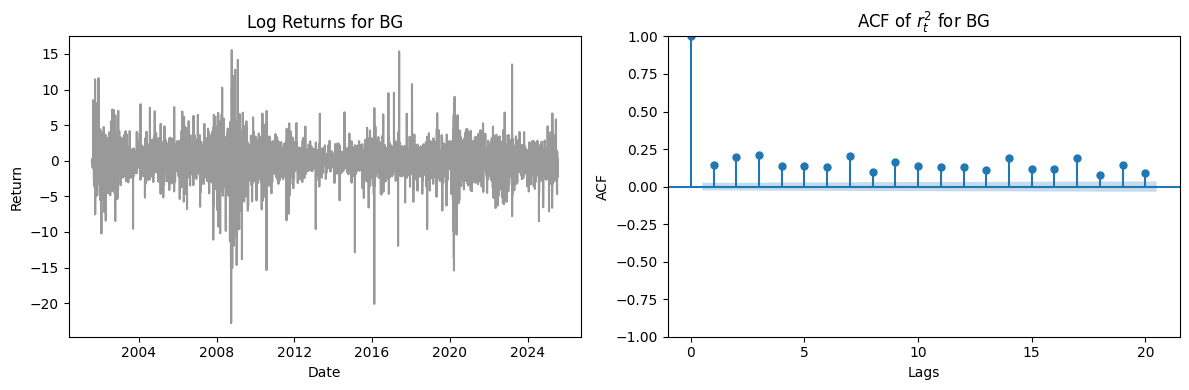

In [85]:
BG_ct = clusteringTest(df_commodity['BG']['returns'],'BG')
BG_ct.plotACF()

In [29]:
commodity_clustering_dict = clustering(df_commodity, sector="commodity")

In [30]:
commodity_clustering = pd.DataFrame.from_dict(commodity_clustering_dict, orient='index', columns=['Sector', '#Observations','Clustering Score'])

In [31]:
commodity_clustering.sort_values(by='Clustering Score', ascending=False)

,Sector,#Observations,Clustering Score
BG,commodity,6023,0.815
NEM,commodity,6465,0.717
ADM,commodity,6465,0.538
MOS,commodity,6465,0.527
FCX,commodity,6465,0.168
SLB,commodity,6465,0.096
CVX,commodity,6465,0.072
GOLD,commodity,4134,0.041
XOM,commodity,6465,0.038


## Concat all sectors

In [32]:
clustering_all = pd.concat([
    finance_clustering,
    tech_clustering,
    etf_clustering,
    health_tech_clustering,
    commodity_clustering
])

In [33]:
clustering_all.sort_values(by='Clustering Score', ascending=False, inplace=True)
clustering_all.reset_index(inplace=True)
clustering_all.rename(columns={"index":"Ticker"},inplace=True)

In [34]:
clustering_all.head(10)

,Ticker,Sector,#Observations,Clustering Score
0,DIA,ETF,6465,1.615
1,SPY,ETF,6458,1.528
2,TLT,ETF,5780,1.507
3,XLF,ETF,6465,1.290
4,ARKK,ETF,2691,1.269
5,XLK,ETF,6465,1.219
6,GS,Finance,6463,1.069
7,BG,commodity,6023,0.815
8,NEM,commodity,6465,0.717
9,JPM,Finance,6463,0.697


In [35]:
clustering_all.tail(5)

,Ticker,Sector,#Observations,Clustering Score
42,AAPL,Technology,6463,-0.000
43,AVGO,Technology,4008,-0.000
44,CRM,Technology,5298,-0.000
45,GOOGL,Technology,5258,-0.001
46,VXX,ETF,4140,-0.008


In [38]:
clustering_all.to_csv("results/clustering_scores.csv",index=False)